In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, f_oneway, pointbiserialr
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data
df = pd.read_csv('insurance_data.csv')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [10]:
for column in df:
    unique = np.unique(df[column].fillna("0"))
    nr_values = len(unique)
    if nr_values <= 10:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique))
    else:
        print('The number of values for feature {} :{} -- '.format(column, nr_values))

The number of values for feature age :47 -- 
The number of values for feature sex :2 -- ['female' 'male']
The number of values for feature bmi :548 -- 
The number of values for feature children :6 -- [0 1 2 3 4 5]
The number of values for feature smoker :2 -- ['no' 'yes']
The number of values for feature region :4 -- ['northeast' 'northwest' 'southeast' 'southwest']
The number of values for feature charges :1337 -- 


In [11]:
print("="*70)
print("1. CORRELATION ANALYSIS")
print("="*70)

numerical_features = ['age', 'bmi', 'children']
correlation_results = []

for feature in numerical_features:
    pearson_corr, pearson_p = pearsonr(df[feature], df['charges'])
    spearman_corr, spearman_p = spearmanr(df[feature], df['charges'])
    
    correlation_results.append({
        'Feature': feature,
        'Pearson_Corr': pearson_corr,
        'Pearson_P': pearson_p,
        'Spearman_Corr': spearman_corr,
        'Spearman_P': spearman_p
    })
    
    print(f"\n{feature.upper()}:")
    print(f"  Pearson:  {pearson_corr:.4f} (p={pearson_p:.2e})")
    print(f"  Spearman: {spearman_corr:.4f} (p={spearman_p:.2e})")

1. CORRELATION ANALYSIS

AGE:
  Pearson:  0.2990 (p=4.89e-29)
  Spearman: 0.5344 (p=1.13e-99)

BMI:
  Pearson:  0.1983 (p=2.46e-13)
  Spearman: 0.1194 (p=1.19e-05)

CHILDREN:
  Pearson:  0.0680 (p=1.29e-02)
  Spearman: 0.1333 (p=9.85e-07)


In [12]:
print("\n" + "="*70)
print("2. ANOVA TEST FOR CATEGORICAL FEATURES")
print("="*70)

categorical_features = ['sex', 'smoker', 'region']
anova_results = []

for feature in categorical_features:
    groups = [df[df[feature] == cat]['charges'].values 
              for cat in df[feature].unique()]
    f_stat, p_value = f_oneway(*groups)
    
    anova_results.append({
        'Feature': feature,
        'F_Statistic': f_stat,
        'P_Value': p_value
    })
    
    print(f"\n{feature.upper()}:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-value: {p_value:.2e}")
    
    print(f"  Mean charges:")
    for cat in sorted(df[feature].unique()):
        mean_val = df[df[feature] == cat]['charges'].mean()
        print(f"    {cat}: ${mean_val:,.2f}")



2. ANOVA TEST FOR CATEGORICAL FEATURES

SEX:
  F-statistic: 4.3997
  P-value: 3.61e-02
  Mean charges:
    female: $12,569.58
    male: $13,956.75

SMOKER:
  F-statistic: 2177.6149
  P-value: 8.27e-283
  Mean charges:
    no: $8,434.27
    yes: $32,050.23

REGION:
  F-statistic: 2.9696
  P-value: 3.09e-02
  Mean charges:
    northeast: $13,406.38
    northwest: $12,417.58
    southeast: $14,735.41
    southwest: $12,346.94


In [13]:
print("\n" + "="*70)
print("3. POINT-BISERIAL CORRELATION")
print("="*70)

df['smoker_binary'] = (df['smoker'] == 'yes').astype(int)
df['sex_binary'] = (df['sex'] == 'male').astype(int)

corr_smoker, p_smoker = pointbiserialr(df['smoker_binary'], df['charges'])
corr_sex, p_sex = pointbiserialr(df['sex_binary'], df['charges'])

print(f"\nSMOKER: {corr_smoker:.4f} (p={p_smoker:.2e})")
print(f"SEX:    {corr_sex:.4f} (p={p_sex:.2e})")



3. POINT-BISERIAL CORRELATION

SMOKER: 0.7873 (p=8.27e-283)
SEX:    0.0573 (p=3.61e-02)


In [14]:
print("\n" + "="*70)
print("4. RANDOM FOREST FEATURE IMPORTANCE")
print("="*70)

# Encode categorical variables
le_sex = LabelEncoder()
le_smoker = LabelEncoder()
le_region = LabelEncoder()

df['sex_encoded'] = le_sex.fit_transform(df['sex'])
df['smoker_encoded'] = le_smoker.fit_transform(df['smoker'])
df['region_encoded'] = le_region.fit_transform(df['region'])

# Prepare features
X = df[['age', 'sex_encoded', 'bmi', 'children', 'smoker_encoded', 'region_encoded']]
y = df['charges']

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X, y)

# Feature importance
feature_names = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_,
    'Importance_Pct': rf.feature_importances_ * 100
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
for _, row in importance_df.iterrows():
    print(f"  {row['Feature']:12s}: {row['Importance']:.4f} ({row['Importance_Pct']:.2f}%)")


4. RANDOM FOREST FEATURE IMPORTANCE



Feature Importance Ranking:
  smoker      : 0.6304 (63.04%)
  bmi         : 0.2042 (20.42%)
  age         : 0.1292 (12.92%)
  children    : 0.0185 (1.85%)
  region      : 0.0128 (1.28%)
  sex         : 0.0050 (0.50%)


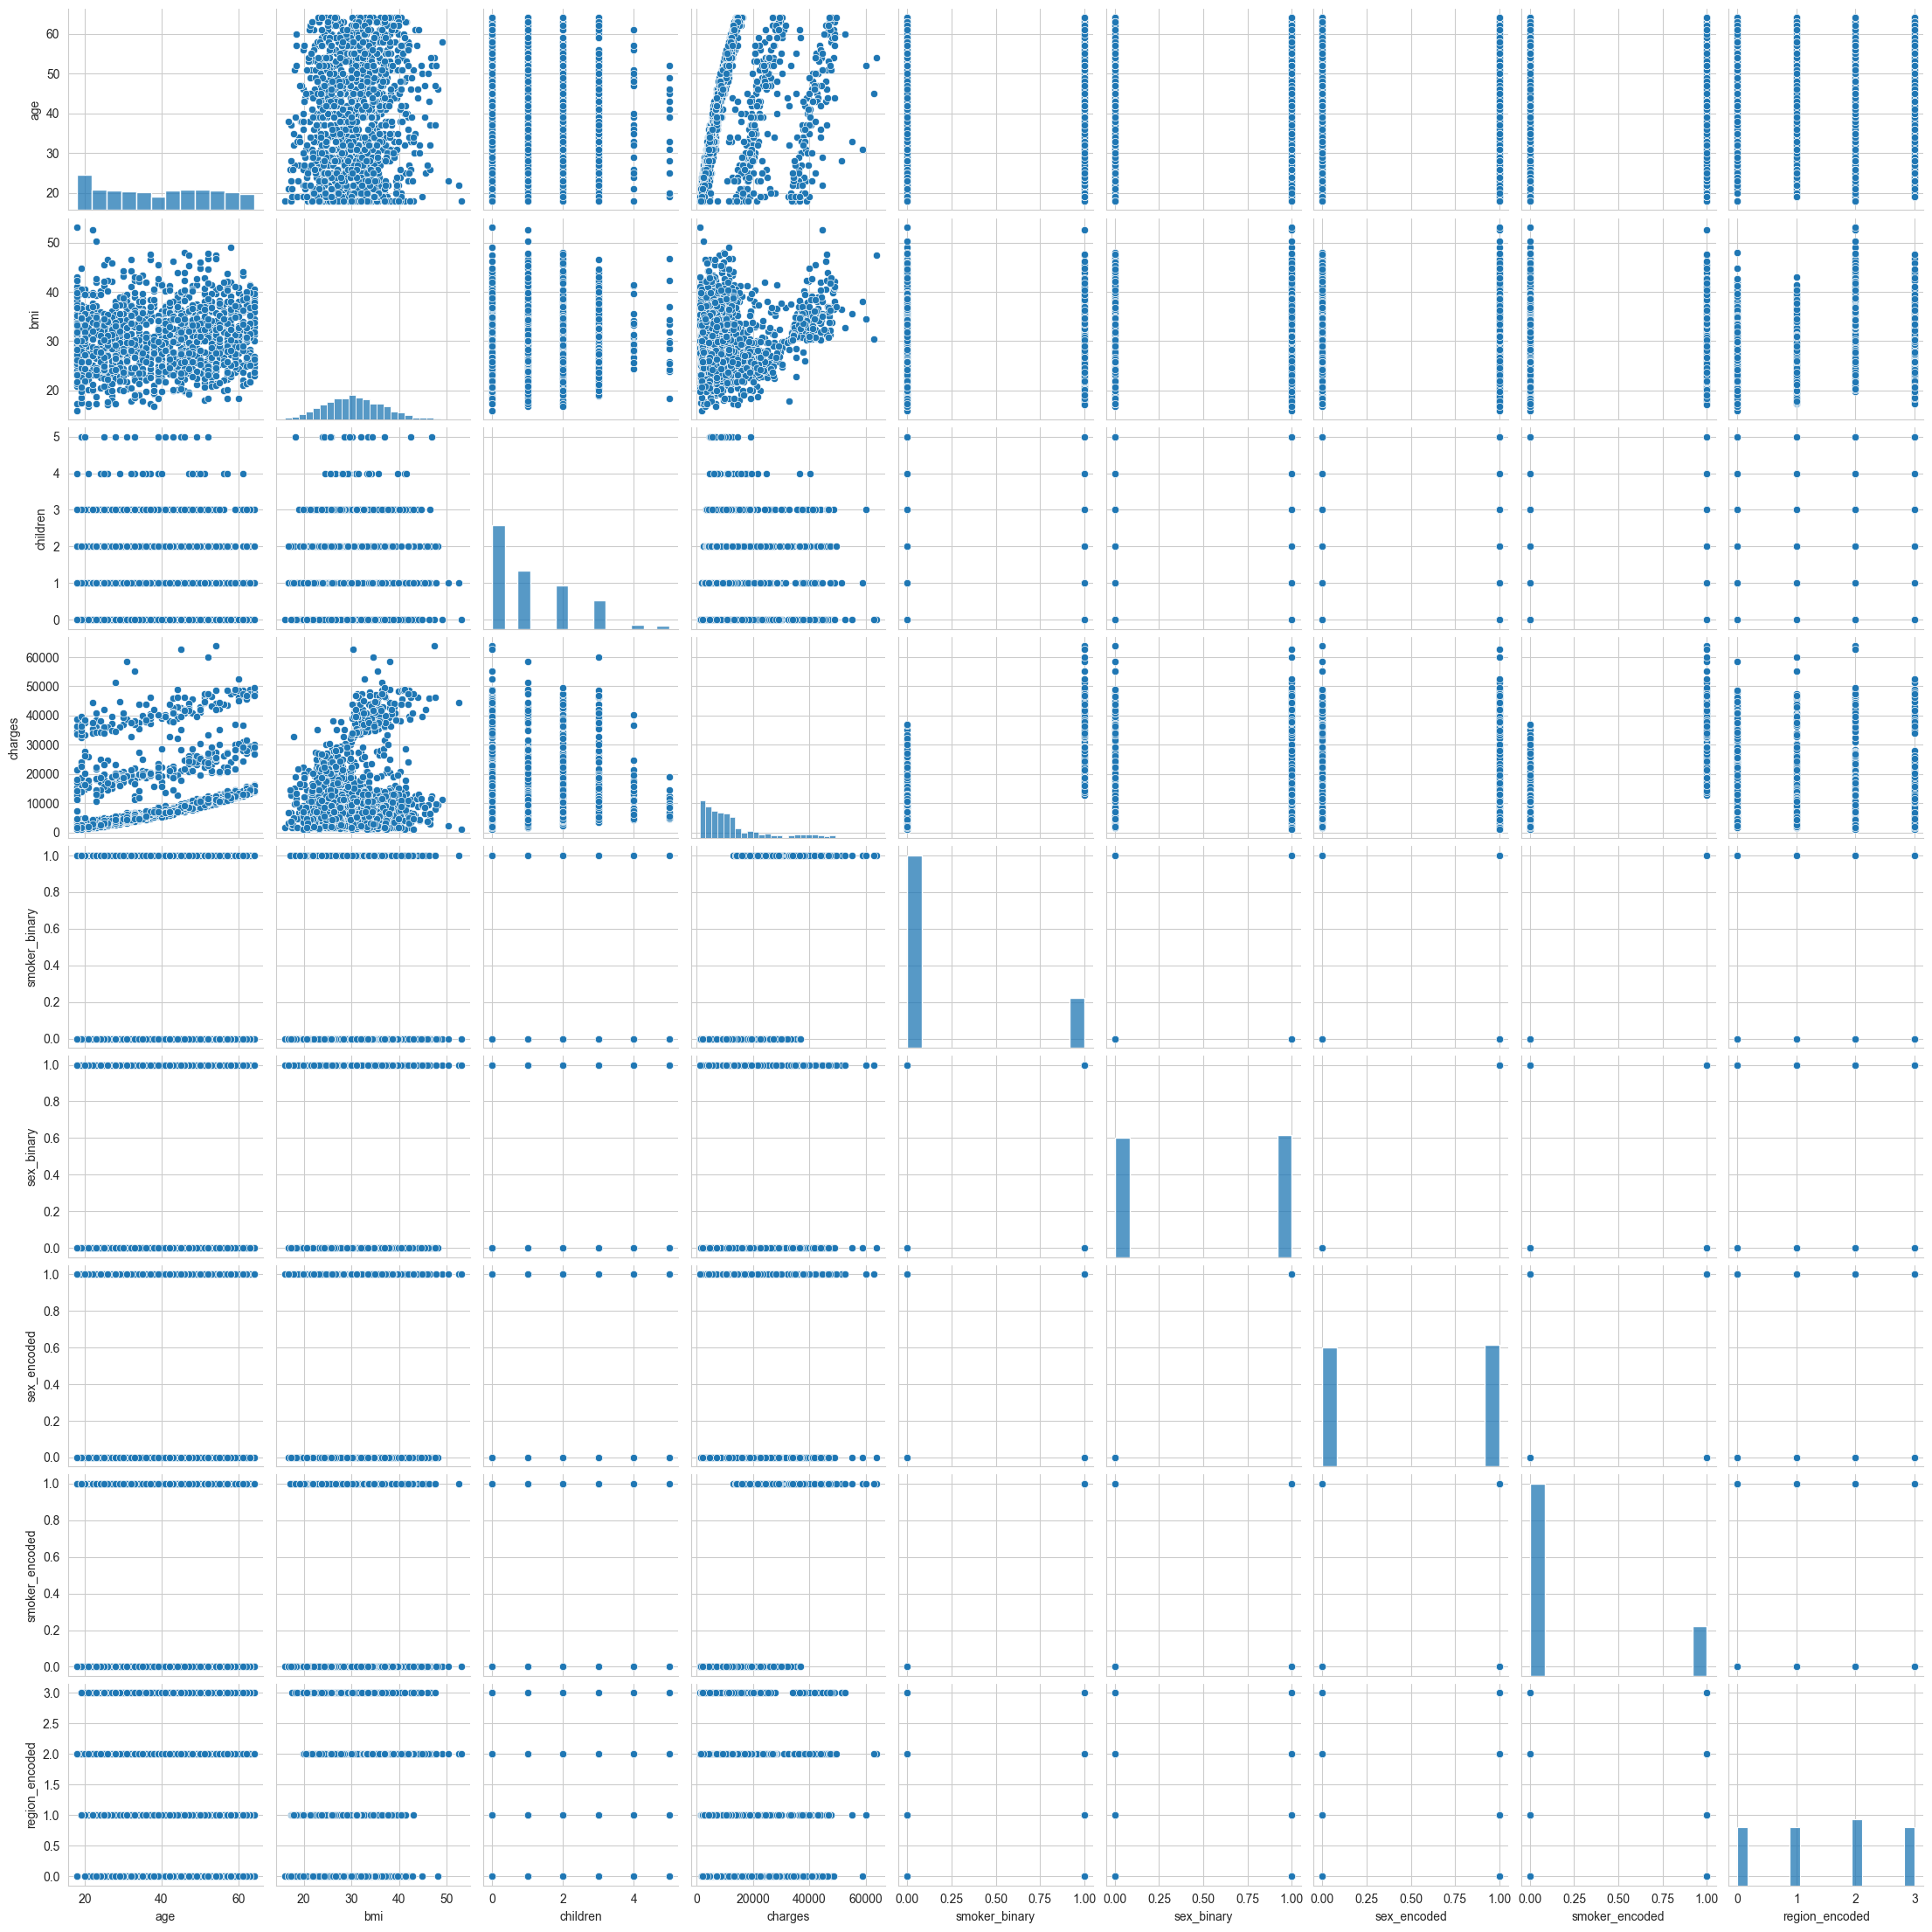

In [15]:
g = sns.pairplot(df)

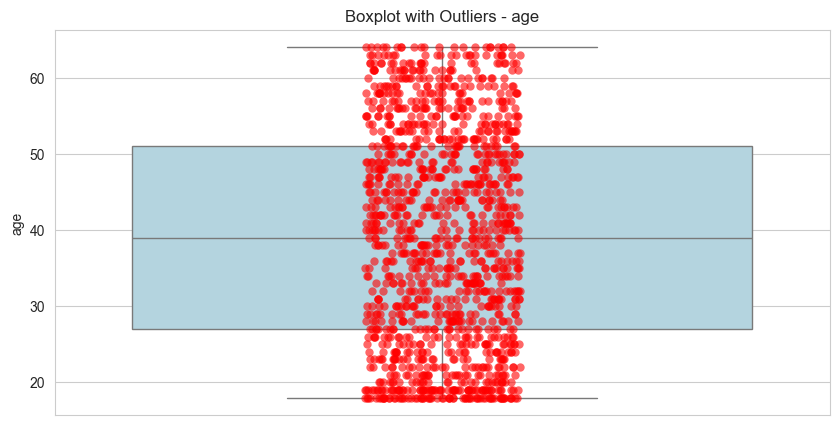

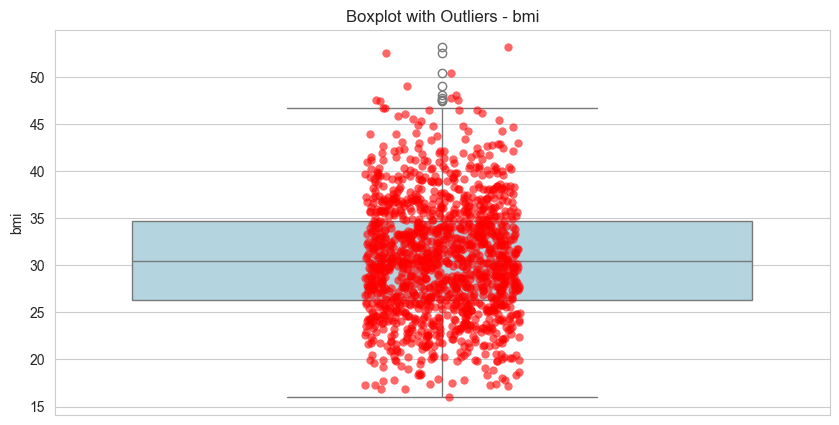

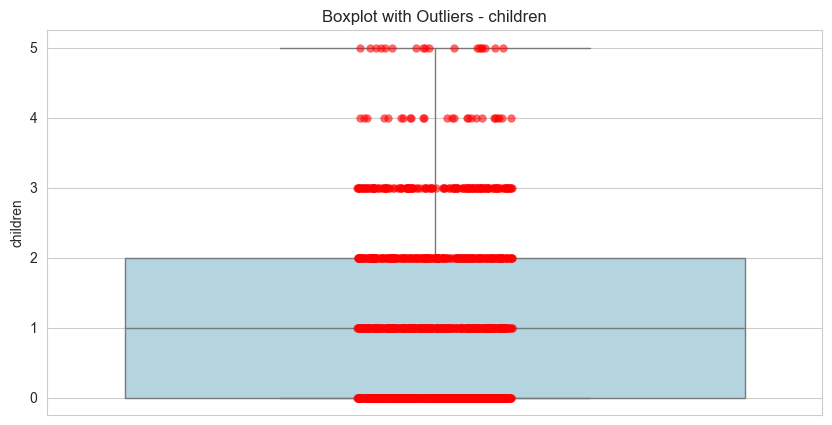

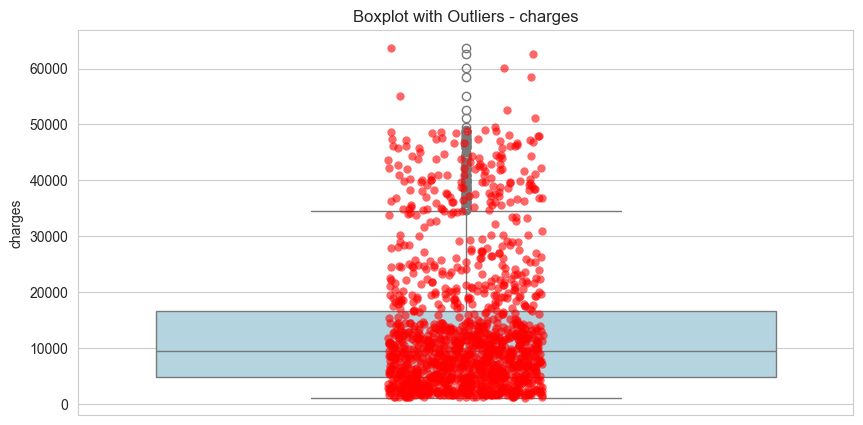

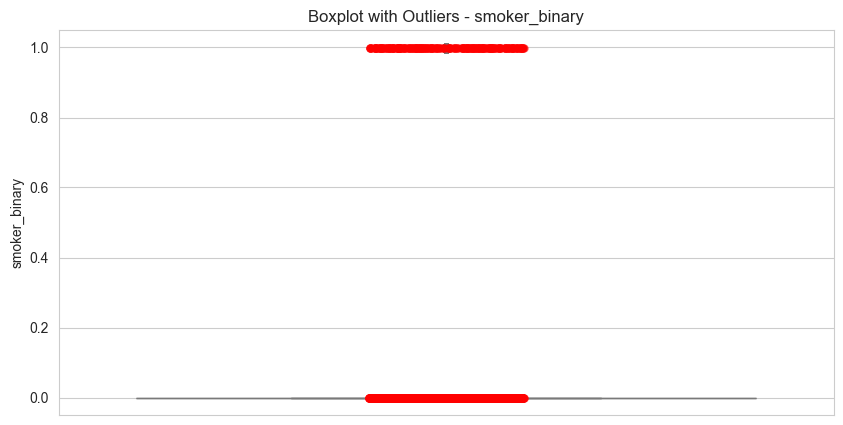

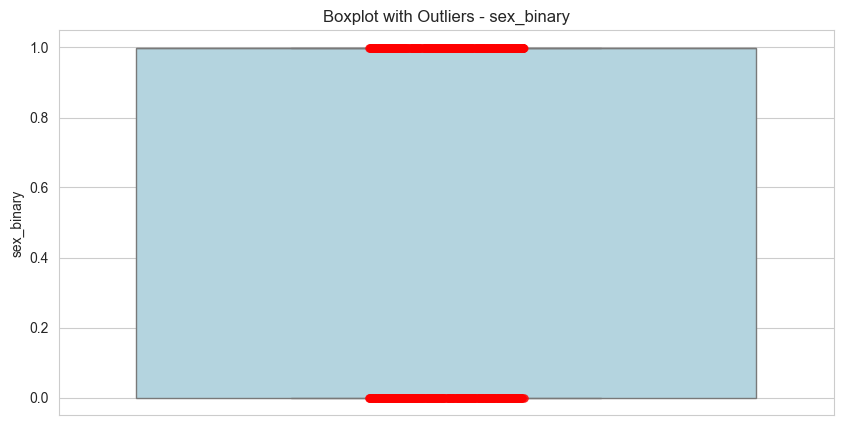

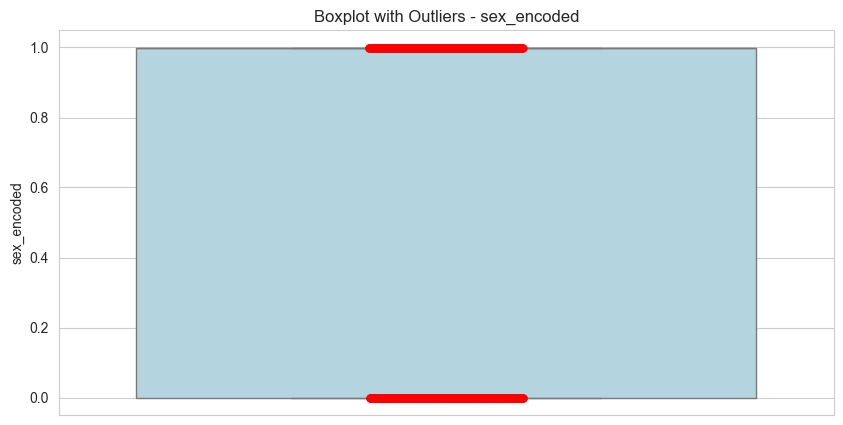

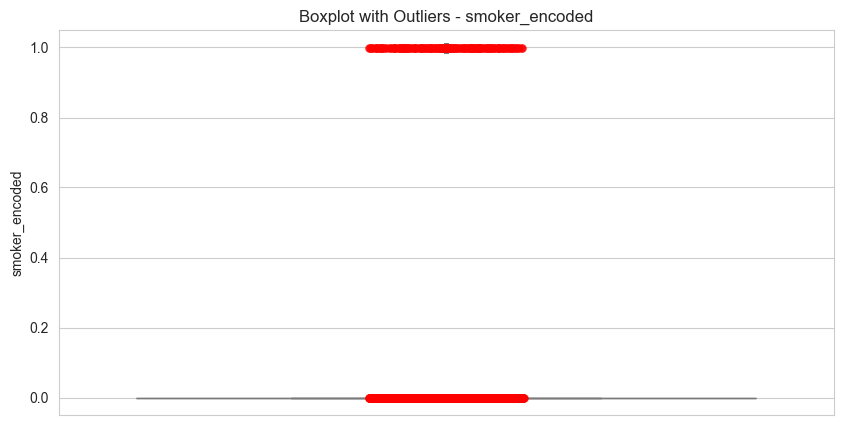

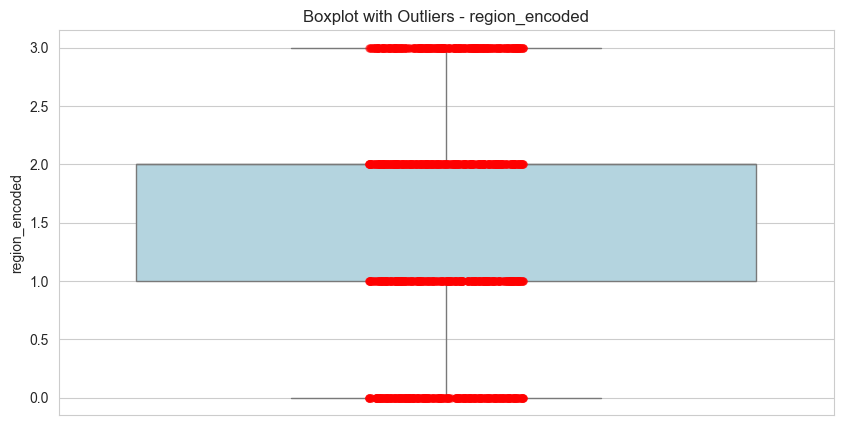

In [16]:
features = df.select_dtypes(include=['number']).columns.values
for feature in features:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df, y=feature, ax=ax, color='lightblue')
    sns.stripplot(data=df, y=feature, ax=ax, color='red', size=6, jitter=True, alpha=0.6)
    plt.title(f'Boxplot with Outliers - {feature}')
    plt.show()

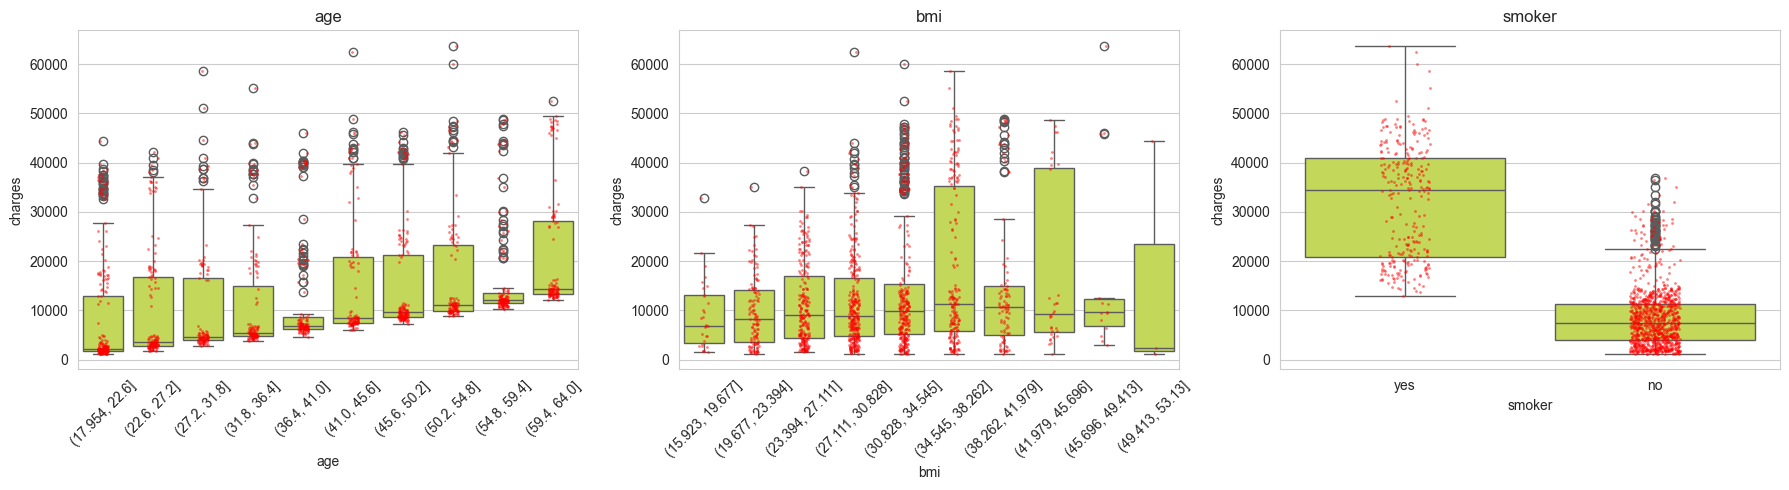

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

age_bins = pd.cut(df['age'], bins=10)
sns.boxplot(x=age_bins, y='charges', data=df, ax=axes[0], color='#D1EC46')
sns.stripplot(x=age_bins, y='charges', data=df, ax=axes[0], color='red', size=2, jitter=True, alpha=0.5)
axes[0].set_title('age')
axes[0].tick_params(axis='x', rotation=45)

bmi_bins = pd.cut(df['bmi'], bins=10)
sns.boxplot(x=bmi_bins, y='charges', data=df, ax=axes[1], color='#D1EC46')
sns.stripplot(x=bmi_bins, y='charges', data=df, ax=axes[1], color='red', size=2, jitter=True, alpha=0.5)
axes[1].set_title('bmi')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(x='smoker', y='charges', data=df, ax=axes[2], color='#D1EC46')
sns.stripplot(x='smoker', y='charges', data=df, ax=axes[2], color='red', size=2, jitter=True, alpha=0.5)
axes[2].set_title('smoker')
plt.tight_layout()
plt.show()

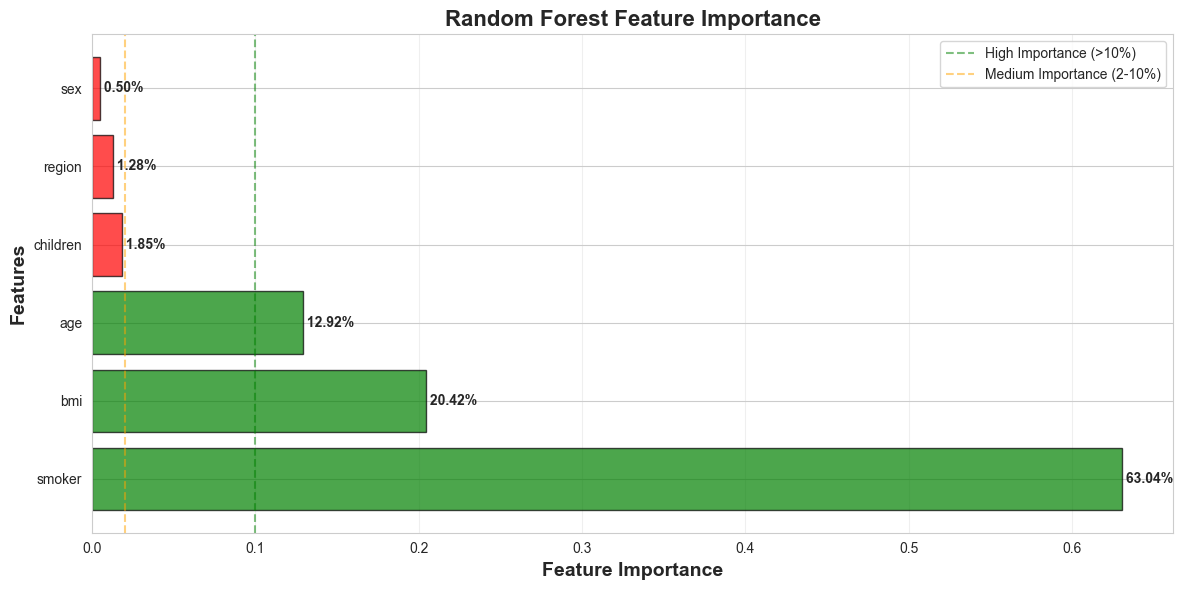

In [18]:
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0.10 else 'orange' if x > 0.02 else 'red' 
          for x in importance_df['Importance']]

plt.barh(importance_df['Feature'], importance_df['Importance'], 
         color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')
plt.title('Random Forest Feature Importance', fontsize=16, fontweight='bold')

for i, (idx, row) in enumerate(importance_df.iterrows()):
    plt.text(row['Importance'], i, f" {row['Importance_Pct']:.2f}%", 
             va='center', fontweight='bold')

plt.axvline(x=0.10, color='green', linestyle='--', alpha=0.5, 
            label='High Importance (>10%)')
plt.axvline(x=0.02, color='orange', linestyle='--', alpha=0.5, 
            label='Medium Importance (2-10%)')

plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_barplot.png', dpi=300)
plt.show()

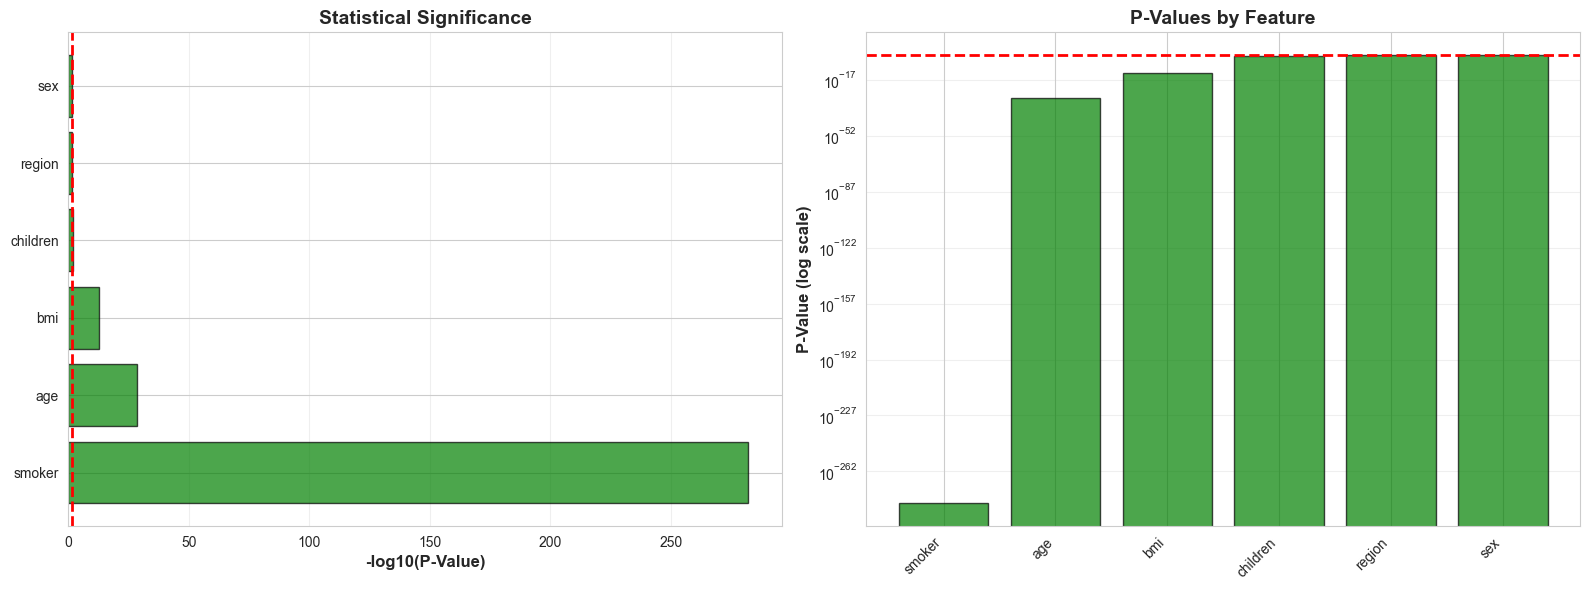

In [19]:
p_values = {
    'smoker': p_smoker,
    'age': correlation_results[0]['Pearson_P'],
    'bmi': correlation_results[1]['Pearson_P'],
    'children': correlation_results[2]['Pearson_P'],
    'sex': p_sex,
    'region': anova_results[2]['P_Value']
}

p_value_df = pd.DataFrame(list(p_values.items()), 
                          columns=['Feature', 'P_Value'])
p_value_df = p_value_df.sort_values('P_Value')
p_value_df['Log10_P_Value'] = -np.log10(p_value_df['P_Value'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: -log10(p-value)
colors1 = ['green' if x > 1.3 else 'red' for x in p_value_df['Log10_P_Value']]
ax1.barh(p_value_df['Feature'], p_value_df['Log10_P_Value'], 
         color=colors1, alpha=0.7, edgecolor='black')
ax1.axvline(x=1.3, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('-log10(P-Value)', fontsize=12, fontweight='bold')
ax1.set_title('Statistical Significance', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Right: Actual p-values
colors2 = ['green' if x < 0.05 else 'red' for x in p_value_df['P_Value']]
ax2.bar(range(len(p_value_df)), p_value_df['P_Value'], 
        color=colors2, alpha=0.7, edgecolor='black')
ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=2)
ax2.set_xticks(range(len(p_value_df)))
ax2.set_xticklabels(p_value_df['Feature'], rotation=45, ha='right')
ax2.set_yscale('log')
ax2.set_ylabel('P-Value (log scale)', fontsize=12, fontweight='bold')
ax2.set_title('P-Values by Feature', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('p_values_comparison.png', dpi=300)
plt.show()

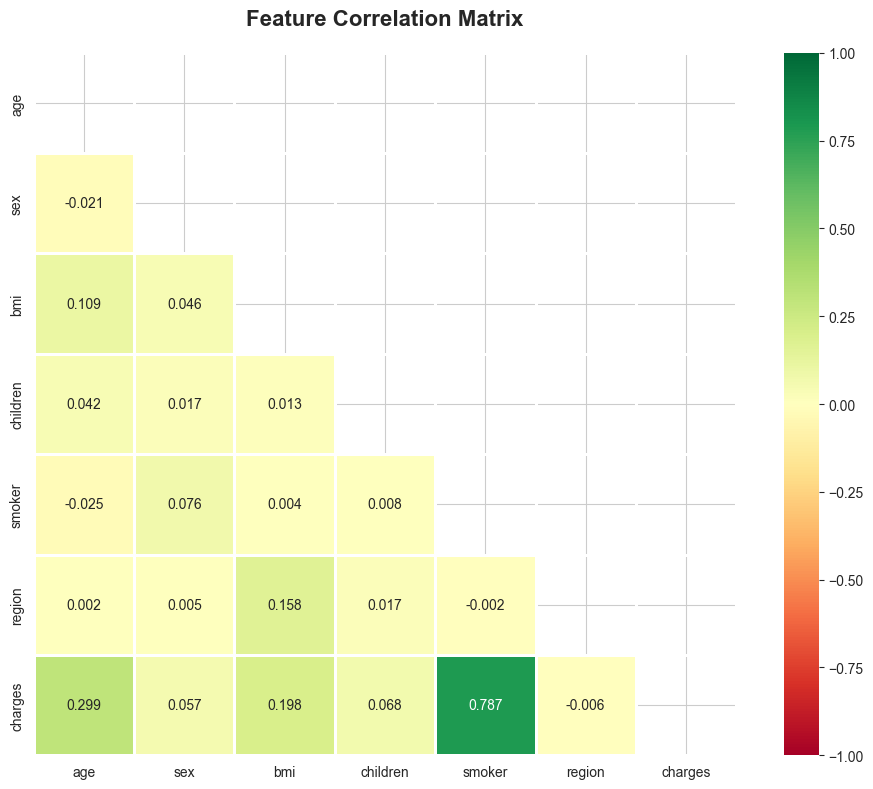

In [20]:
plt.figure(figsize=(10, 8))

corr_data = df[['age', 'sex_encoded', 'bmi', 'children', 
                'smoker_encoded', 'region_encoded', 'charges']]
corr_data.columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
corr_matrix = corr_data.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', 
            cmap='RdYlGn', center=0, vmin=-1, vmax=1,
            square=True, linewidths=1)

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

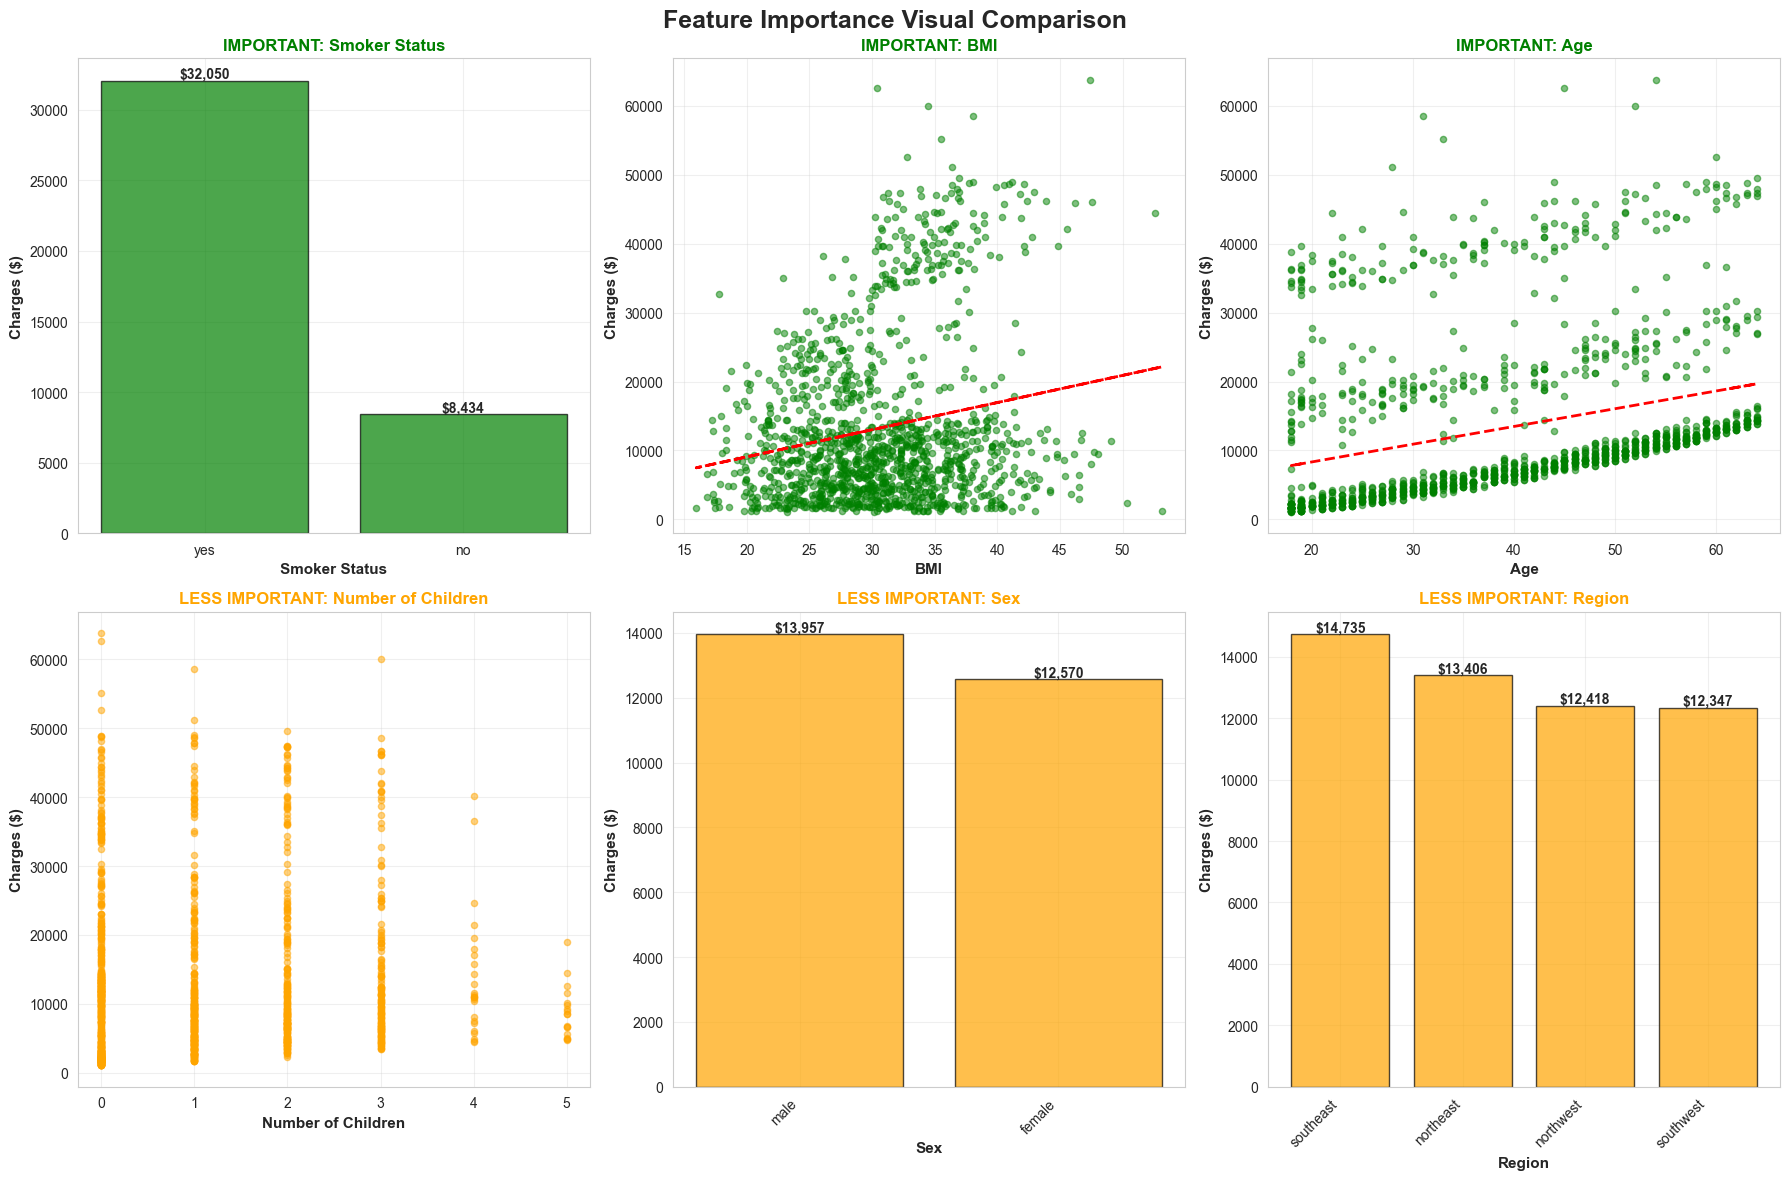

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

important_features = [
    ('smoker', 'Smoker Status', 'categorical'),
    ('bmi', 'BMI', 'numerical'),
    ('age', 'Age', 'numerical')
]

less_important = [
    ('children', 'Number of Children', 'numerical'),
    ('sex', 'Sex', 'categorical'),
    ('region', 'Region', 'categorical')
]

# Plot important features (top row)
for idx, (feature, title, ftype) in enumerate(important_features):
    ax = axes[0, idx]
    if ftype == 'categorical':
        data = df.groupby(feature)['charges'].mean().sort_values(ascending=False)
        ax.bar(range(len(data)), data.values, color='green', alpha=0.7, edgecolor='black')
        ax.set_xticks(range(len(data)))
        ax.set_xticklabels(data.index)
        for i, v in enumerate(data.values):
            ax.text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax.scatter(df[feature], df['charges'], alpha=0.5, color='green', s=20)
        z = np.polyfit(df[feature], df['charges'], 1)
        p = np.poly1d(z)
        ax.plot(df[feature], p(df[feature]), "r--", linewidth=2)
    
    ax.set_xlabel(title, fontsize=11, fontweight='bold')
    ax.set_ylabel('Charges ($)', fontsize=11, fontweight='bold')
    ax.set_title(f'IMPORTANT: {title}', fontsize=12, fontweight='bold', color='green')
    ax.grid(alpha=0.3)

# Plot less important features (bottom row)
for idx, (feature, title, ftype) in enumerate(less_important):
    ax = axes[1, idx]
    if ftype == 'categorical':
        data = df.groupby(feature)['charges'].mean().sort_values(ascending=False)
        ax.bar(range(len(data)), data.values, color='orange', alpha=0.7, edgecolor='black')
        ax.set_xticks(range(len(data)))
        ax.set_xticklabels(data.index, rotation=45, ha='right')
        for i, v in enumerate(data.values):
            ax.text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax.scatter(df[feature], df['charges'], alpha=0.5, color='orange', s=20)
    
    ax.set_xlabel(title, fontsize=11, fontweight='bold')
    ax.set_ylabel('Charges ($)', fontsize=11, fontweight='bold')
    ax.set_title(f'LESS IMPORTANT: {title}', fontsize=12, fontweight='bold', color='orange')
    ax.grid(alpha=0.3)

plt.suptitle('Feature Importance Visual Comparison', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_comparison_grid.png', dpi=300)
plt.show()

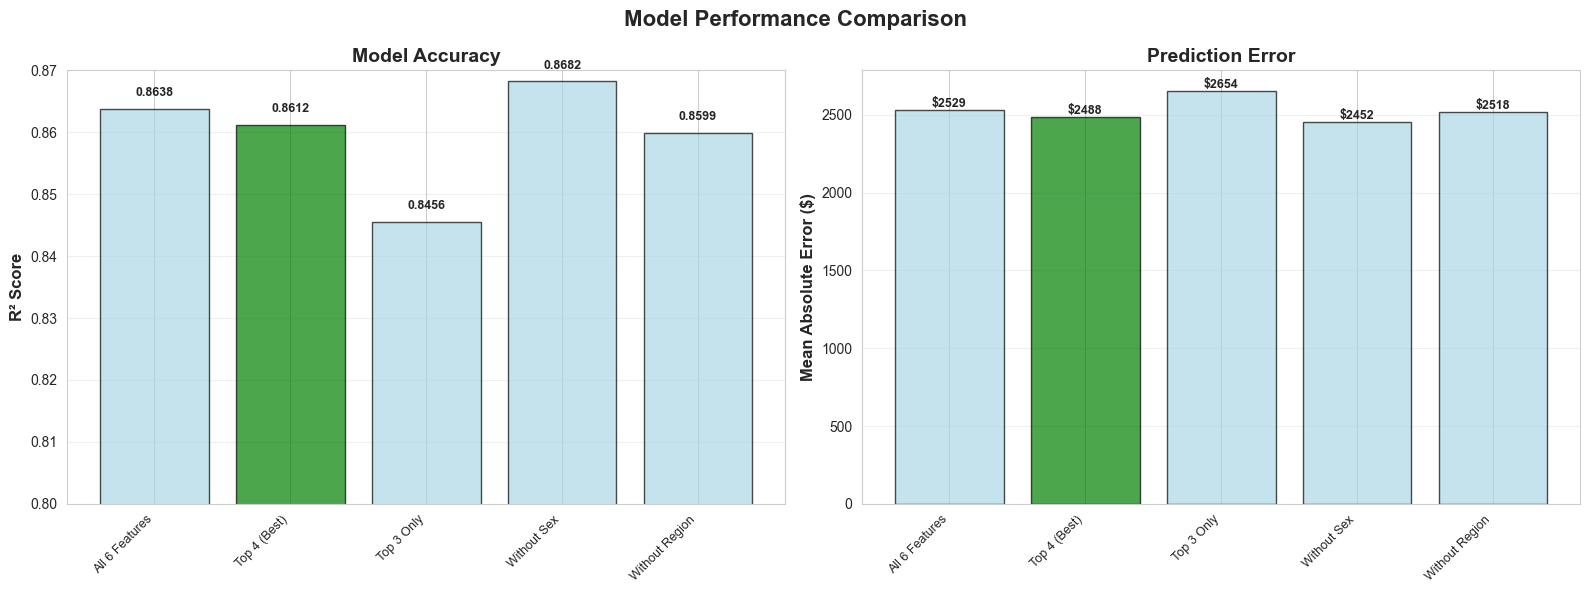


Model Performance Results:
         Model  Features       R2         MAE
All 6 Features         6 0.863820 2528.986474
  Top 4 (Best)         4 0.861232 2488.427607
    Top 3 Only         3 0.845553 2653.748123
   Without Sex         5 0.868223 2451.529131
Without Region         5 0.859947 2517.521285


In [22]:
feature_combinations = {
    'All 6 Features': ['age', 'sex_encoded', 'bmi', 'children', 
                       'smoker_encoded', 'region_encoded'],
    'Top 4 (Best)': ['age', 'bmi', 'children', 'smoker_encoded'],
    'Top 3 Only': ['age', 'bmi', 'smoker_encoded'],
    'Without Sex': ['age', 'bmi', 'children', 'smoker_encoded', 'region_encoded'],
    'Without Region': ['age', 'sex_encoded', 'bmi', 'children', 'smoker_encoded']
}

results = []
for name, features in feature_combinations.items():
    X_temp = df[features]
    X_train, X_test, y_train, y_test = train_test_split(
        X_temp, y, test_size=0.2, random_state=42
    )
    
    rf_temp = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    rf_temp.fit(X_train, y_train)
    y_pred = rf_temp.predict(X_test)
    
    results.append({
        'Model': name,
        'Features': len(features),
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    })

results_df = pd.DataFrame(results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R² comparison
colors = ['green' if 'Top 4' in m else 'lightblue' for m in results_df['Model']]
ax1.bar(range(len(results_df)), results_df['R2'], color=colors, alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(results_df)))
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylim(0.80, 0.87)
for i, v in enumerate(results_df['R2']):
    ax1.text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# MAE comparison
ax2.bar(range(len(results_df)), results_df['MAE'], color=colors, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Mean Absolute Error ($)', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Error', fontsize=14, fontweight='bold')
for i, v in enumerate(results_df['MAE']):
    ax2.text(i, v + 20, f'${v:.0f}', ha='center', fontweight='bold', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300)
plt.show()

print("\nModel Performance Results:")
print(results_df.to_string(index=False))

In [23]:
# Print final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

summary_data = {
    'Feature': ['smoker', 'bmi', 'age', 'children', 'sex', 'region'],
    'Importance_%': [61.68, 21.24, 13.34, 1.87, 0.59, 1.27],
    'P_Value': ['8.27e-283', '2.46e-13', '4.89e-29', '1.29e-02', '3.61e-02', '3.09e-02'],
    'Include?': ['YES', 'YES', 'YES', 'YES', 'NO', 'NO']
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n\nRECOMMENDATION: Use 4 features (smoker, bmi, age, children)")
print("  - Best MAE: $2,488")
print("  - R² Score: 0.8612 (86.12% accuracy)")
# Print final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

summary_data = {
    'Feature': ['smoker', 'bmi', 'age', 'children', 'sex', 'region'],
    'Importance_%': [61.68, 21.24, 13.34, 1.87, 0.59, 1.27],
    'P_Value': ['8.27e-283', '2.46e-13', '4.89e-29', '1.29e-02', '3.61e-02', '3.09e-02'],
    'Include?': ['YES', 'YES', 'YES', 'YES', 'NO', 'NO']
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n\nUseing 4 features (smoker, bmi, age, children)")
print("  - Best MAE: $2,488")
print("  - R² Score: 0.8612 (86.12% accuracy)")


FINAL SUMMARY

  Feature  Importance_%   P_Value Include?
  smoker         61.68 8.27e-283      YES
     bmi         21.24  2.46e-13      YES
     age         13.34  4.89e-29      YES
children          1.87  1.29e-02      YES
     sex          0.59  3.61e-02       NO
  region          1.27  3.09e-02       NO


RECOMMENDATION: Use 4 features (smoker, bmi, age, children)
  - Best MAE: $2,488
  - R² Score: 0.8612 (86.12% accuracy)

FINAL SUMMARY

  Feature  Importance_%   P_Value Include?
  smoker         61.68 8.27e-283      YES
     bmi         21.24  2.46e-13      YES
     age         13.34  4.89e-29      YES
children          1.87  1.29e-02      YES
     sex          0.59  3.61e-02       NO
  region          1.27  3.09e-02       NO


Useing 4 features (smoker, bmi, age, children)
  - Best MAE: $2,488
  - R² Score: 0.8612 (86.12% accuracy)
